In [1]:
# Set your student number
Name = 'Amir Hossein'
Last_Name = 'Rahmati'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.io import loadmat


NUM_PIXELS = 28*28

In [3]:
def load_model(model_file):
    '''
    Loads a default Bayesian network with latent variables (in this case, a
    variational autoencoder)
    '''

    with open(model_file, 'rb') as infile:
        cpts = pkl.load(infile, encoding='bytes')

    model = {}
    model['prior_z1'] = cpts[0]
    model['prior_z2'] = cpts[1]
    model['cond_likelihood'] = cpts[2]

    return model

In [4]:
global disc_z1, disc_z2
n_disc_z = 25
disc_z1 = np.linspace(-3, 3, n_disc_z)
disc_z2 = np.linspace(-3, 3, n_disc_z)

global bayes_net
bayes_net = load_model('./trained_mnist_model')

In [5]:
def get_p_z1(z1_val):
    '''
    Helper. Computes the prior probability for variable z1 to take value z1_val.
    P(Z1=z1_val)
    '''

    return bayes_net['prior_z1'][z1_val]


def get_p_z2(z2_val):
    '''
    Helper. Computes the prior probability for variable z2 to take value z2_val.
    P(Z2=z2_val)
    '''

    return bayes_net['prior_z2'][z2_val]

In [6]:
def get_p_xk_cond_z1_z2(z1_val, z2_val, k):
    '''
    Helper. Computes the conditional probability that variable xk assumes value 1
    given that z1 assumes value z1_val and z2 assumes value z2_val
    P(Xk = 1 | Z1=z1_val , Z2=z2_val)
    '''

    return bayes_net['cond_likelihood'][(z1_val, z2_val)][0, k-1]


def get_p_x_cond_z1_z2(z1_val, z2_val):
    '''
    Computes the conditional probability of the entire vector x for x = 1,
    given that z1 assumes value z1_val and z2 assumes value z2_val
    '''
    pk = np.zeros(NUM_PIXELS)
    for i in range(NUM_PIXELS):
        pk[i] = get_p_xk_cond_z1_z2(z1_val, z2_val, i+1)
    return pk

#### make joint distribution

In [7]:
def get_p_x_z1_z2(x,z1,z2,k):
    p_z1 = get_p_z1(z1)
    p_z2 = get_p_z2(z2)
    p_xk_cond_z1_z2 = get_p_xk_cond_z1_z2(z1, z2, k)
    if x == 1:
        return p_z1*p_z2*p_xk_cond_z1_z2
    else:
        return p_z1*p_z2*(1-p_xk_cond_z1_z2)

In [8]:
z_domain = np.arange(-3, 3.25, 0.25)
x_domain = np.arange(0, 2,1)

joint_domain = list()
for i in range(len(z_domain)):
    for j in range(len(z_domain)):
        for k in range(len(x_domain)):
             joint_domain.append((x_domain[k], z_domain[i], z_domain[j]))

joint_prob = list()
for i in range(784):
    i_th_dist = list()
    for j in range(len(joint_domain)):
        i_th_dist.append(get_p_x_z1_z2(joint_domain[j][0], joint_domain[j][1], joint_domain[j][2], i+1))
    joint_prob.append(i_th_dist)


#### sampling and show

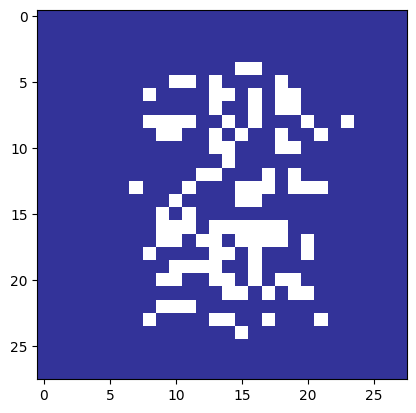

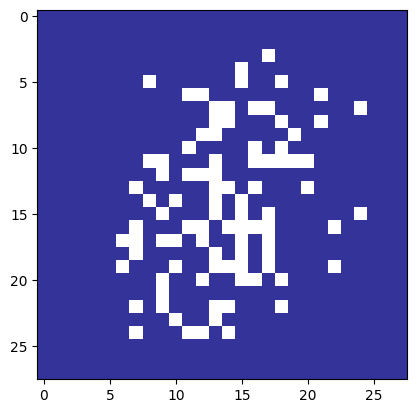

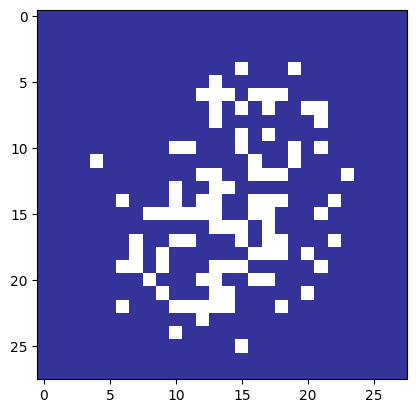

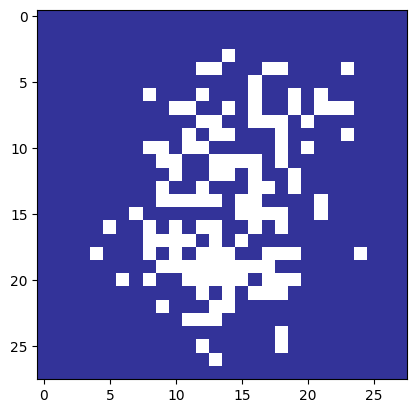

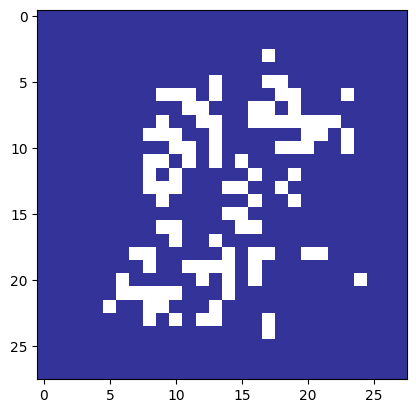

In [9]:
samples = list()
samples_pixels = list()
for i in range(5):
    sample = list()
    sample_pixels = list()
    for j in range(len(joint_prob)):
        indices = np.random.choice(len(joint_domain), p=joint_prob[j])
        sample.append(joint_domain[indices])
        sample_pixels.append(joint_domain[indices][0])
    samples.append(sample)
    samples_pixels.append(sample_pixels)

# show pictures
for i in range(5):
    plt.figure()
    plt.imshow(np.array(samples_pixels[i]).reshape(28,28), cmap= 'terrain')
    plt.show()

#### expected ####

In [10]:
z1_z2_domain = list()
for i in range(len(z_domain)):
    for j in range(len(z_domain)):
        z1_z2_domain.append((z_domain[i], z_domain[j]))
    
z1_z2_prob = list()
for i in range(len(z1_z2_domain)):
    z1_z2_prob.append(get_p_x_cond_z1_z2(z1_z2_domain[i][0], z1_z2_domain[i][1]))

#### plot

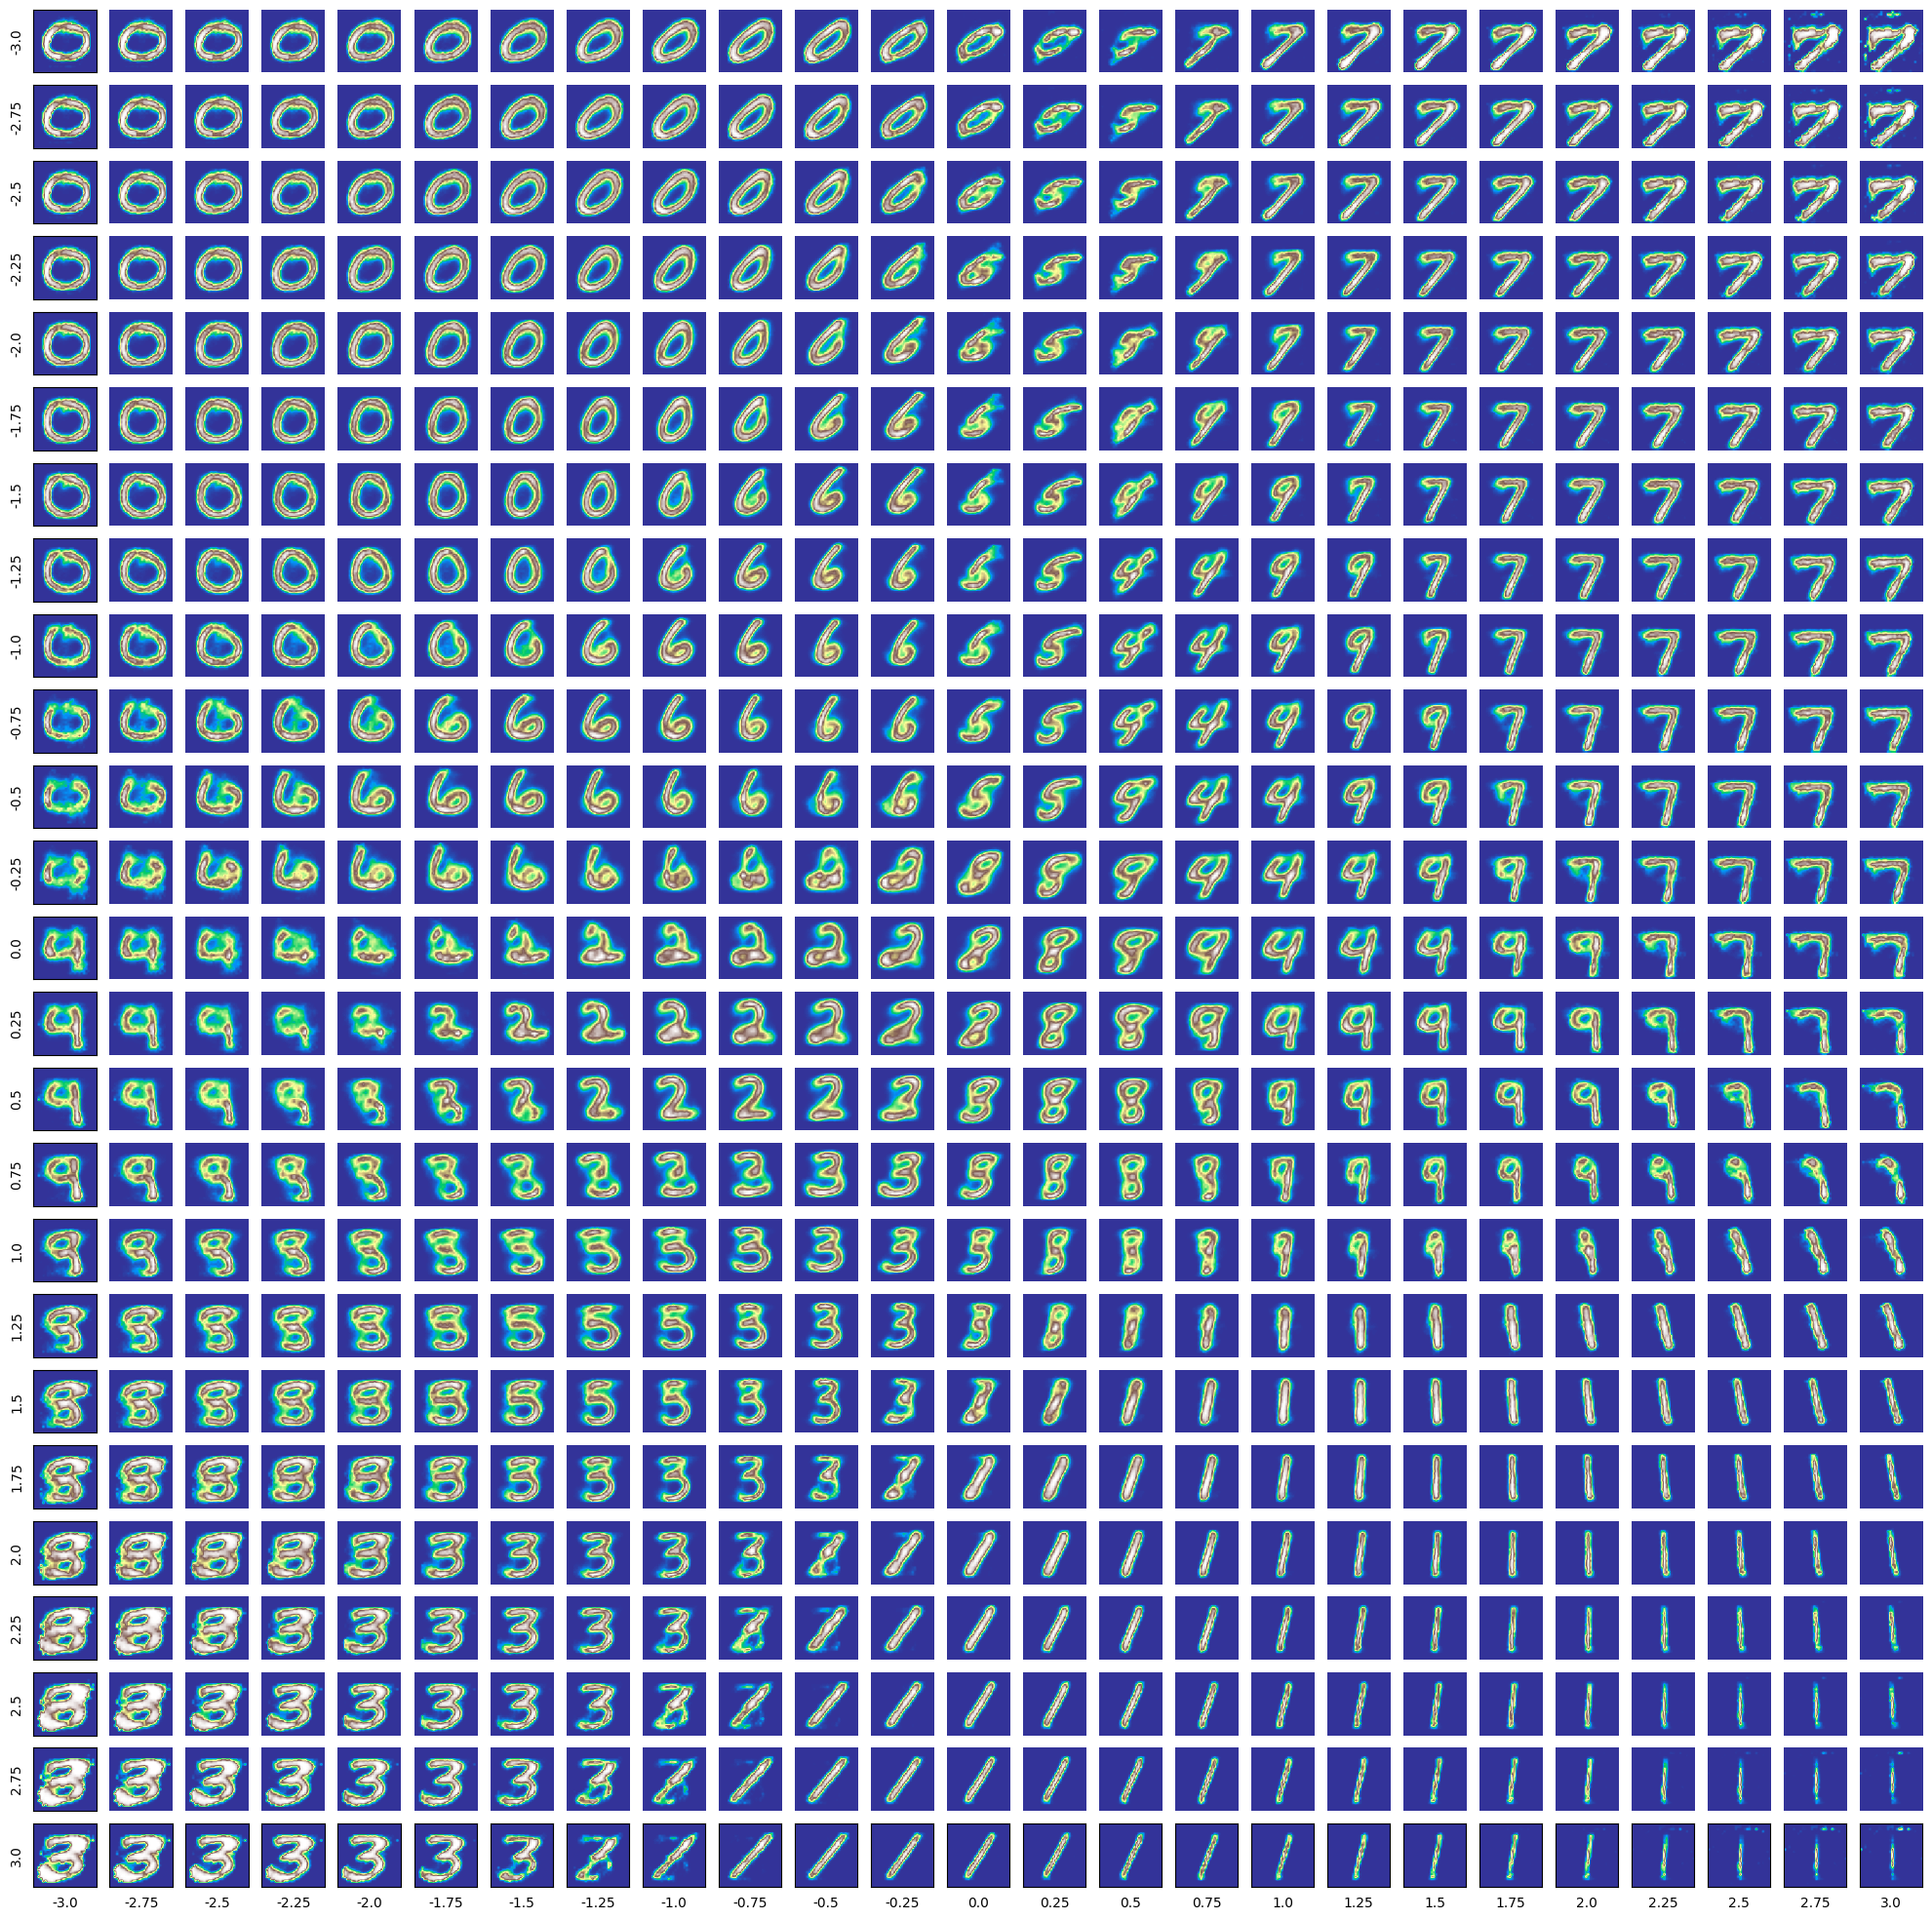

In [12]:
fig , ax = plt.subplots(25,25, figsize=(25,25))
for i in range(25):
    for j in range(25):
        ax[i,j].imshow(np.array(z1_z2_prob[i*25+j]).reshape(28,28), cmap= 'terrain')
        if j == 0 or i == 24 :
            if j == 0:
                ax[i,j].set_yticks([])
                ax[i,j].set_xticks([])
                ax[i,j].set_ylabel(str(z_domain[i]))
            if i == 24:
                ax[i,j].set_yticks([])
                ax[i,j].set_xticks([])
                ax[i,j].set_xlabel(str(z_domain[j]))
        else:
            ax[i,j].axis('off')
plt.show()